In [1]:
import os
import astropy
from astropy.table import Table, QTable
from astropy import units as u
from astropy import constants as consts
from progress_bar import progress_bar
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import argrelmax, argrelmin
from scipy.optimize import curve_fit
from copy import deepcopy
plt.rcParams['figure.dpi'] = 150
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\n'.join(
                                        [r'\usepackage{siunitx}',
                                         r'\usepackage{mhchem}'])

In [2]:
si2 = 6356*u.Angstrom

In [3]:
spectra = Table.read('wiserep_spectra.csv', format='csv', encoding='utf8')

In [4]:
len(spectra)

28314

In [5]:
ia_mask = spectra['Obj. Type'] == 'SN Ia'
ia91bg_mask = spectra['Obj. Type'] == 'SN Ia-91bg-like'
ia91T_mask = spectra['Obj. Type'] == 'SN Ia-91T-like'

snia = spectra[ia_mask]
snia91bg = spectra[ia91bg_mask]
snia191T = spectra[ia91T_mask]

In [6]:
def signal_to_noise(data: np.ndarray):
    mean = data.sum(0)/len(data)
    chi2 = ((data-mean)**2).sum()
    stddev = (chi2/(len(data)-1))**0.5
    s2n = (mean/stddev)**2
    return s2n
def calculate_intervals(x: np.ndarray):
    return  x[1:] - x[0:len(x)-1]

calculate_intervals(np.array([0, 1, 1, 2, 3, 5, 8, 13]))

array([1, 0, 1, 1, 2, 3, 5])

In [7]:
def gaussian(x, x0 = 0, sigma = 1):
    curve = np.exp((-(x-x0)**2)/(2*sigma**2))
    return curve / curve.sum(axis=1)[np.newaxis]

def gaussian_filter(x, x0, y, sigma):
    gauss = gaussian(x, x0, sigma)
    return (y * gauss).sum(axis=1)

def smooth_data(x, y, sigma):
    return gaussian_filter(x, x[:, np.newaxis], y, sigma).T

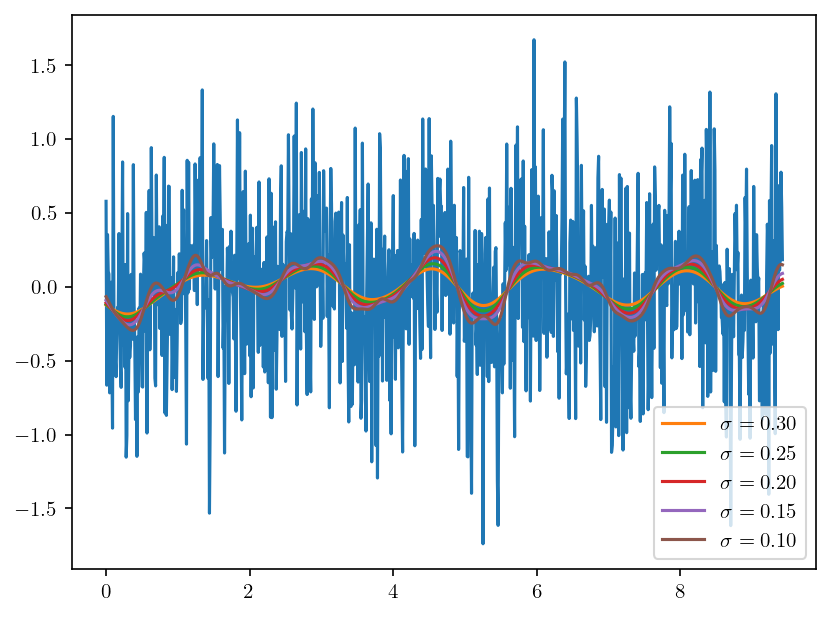

In [8]:
tx = np.arange(0, 3*np.pi, .01)
ty = np.sum([np.random.uniform(0, 10) * np.sin(np.random.uniform(-3*np.pi, 3*np.pi)*tx + np.random.uniform(0, 2*np.pi))+np.random.normal(0, 0.5, len(tx)) for i in range(np.random.randint(1, 10))], axis=0)
plt.plot(tx, ty)
for i in range(6, 1, -1):
    smoothed = smooth_data(tx, ty, i*0.05)
    plt.plot(tx, smoothed, label=rf'$\sigma={i*.05: .2f}$')
plt.legend()

$$\frac{\lambda_0 - \lambda}{\lambda} = z$$
$$\lambda = \lambda_0(z+1)$$

In [9]:
def kde(data: np.ndarray, bins: int | np.ndarray = 100, sigma: float = 1.0) -> list[np.ndarray, np.ndarray]:
    '''
    Returns
    -------
    `list[x, y]`
    '''
    def kde_gaussian(grid: np.ndarray, center: float, sigma: float = 1.0):
        return np.exp(-((grid - center)**2) / (2*sigma))
    if isinstance(bins, np.ndarray):
        r = bins
    else:
        r = np.linspace(np.min(data) - 3*sigma, np.max(data) + 3*sigma, bins)
    
    values = np.zeros_like(r)

    for d in data:
        values += kde_gaussian(r, d, sigma)
    
    return (r, values)

In [10]:
# Need to write my own function because I get a unicode encode error
def write_table_csv(table: Table, output_file: str, encoding='utf8'):
    lines = []
    lines.append(f'{','.join([f'"{key}"' for key in table.keys()])}\n')
    for row in table:
        vals = []
        for val in row.values():
            if isinstance(val, np.number):
                val = val.item()
            elif isinstance(val, u.quantity.Quantity):
                val = val.to_value()
            elif val == np.nan:
                val = ''
            elif isinstance(val, str):
                val = val.replace(',', '-') #get rid of commas in text portions
                if val == '--':
                    val = ''
            elif val is None:
                val = ''
            vals.append(val)
        lines.append(f'{','.join([f'"{val}"' for val in vals])}\n') 
    with open(output_file, 'w', encoding=encoding) as f:
        f.writelines(lines)

In [11]:
def calculate_redshift(observed: float, emitted: float):
    return (observed - emitted) / emitted

def redshift_to_velocity(z, particle_velocity = consts.c):
    return z * particle_velocity

In [12]:
redshift_to_velocity(calculate_redshift(5500*u.Angstrom, si2))

<Quantity -40374818.13215859 m / s>

In [13]:
success_count = 0

analyzed_spectra: Table = deepcopy(spectra)
new_col_names = ['Has SiII','Ejecta Redshift', 'Mean Resolution', 'Signal to Noise', 'Successful Read']
analyzed_spectra.add_columns([[False]*len(spectra) if col in ['Has SiII', ['Successful Read']] else [np.nan]*len(spectra) for col in new_col_names], names=new_col_names)

for i in range(len(spectra)):
    file = f'wiserep_data/{spectra['Ascii file'][i]}'
    try:
        spec: Table = Table.read(f'{file}', format='ascii')
        spec: QTable = QTable([spec.columns[0], spec.columns[1]], names=['Wavelength', 'Flux'], units=[u.Angstrom, None])
        
        success_count += 1
        analyzed_spectra['Successful Read'][i] = True
        analyzed_spectra['Mean Resolution'][i] = calculate_intervals(spec['Wavelength']).to_value().mean()
        analyzed_spectra['Signal to Noise'][i] = signal_to_noise(spec['Flux'])

        z = spectra['Redshift'][i]
        spec['Wavelength'] *= (z+1) #translate the Wavelengths to what they would be if the progenitor had 0 radial velocity
        if (np.max(spec['Wavelength']) >= si2) & (np.min(spec['Wavelength']) < si2):
            while analyzed_spectra['Mean Resolution'][i] < 0.1: #some spectra with higher resolution than necessary causing memory issues
                spec = spec[[bool(i%2) for i in range(len(spec))]]
                analyzed_spectra['Mean Resolution'] = calculate_intervals(spec['Wavelength']).to_value().mean()

            analyzed_spectra['Has SiII'][i] = True
            spec = spec[(spec['Wavelength'] >= 5500*u.Angstrom) & (spec['Wavelength'] <= si2+20*u.Angstrom)]
            spec['Flux'] /= spec['Flux'][-1] #scale flux around the flux of the Si II line
            spec['Flux'] = smooth_data(spec['Wavelength'].to_value(), spec['Flux'], 10)
            spec = spec[spec['Wavelength'] <= si2]

            minima = argrelmin(spec['Flux'], order=20)
            if len(minima[0]) > 0:
                absorption_line = spec['Wavelength'][minima[0][-1]]
                analyzed_spectra['Ejecta Redshift'][i] = calculate_redshift(absorption_line, si2)
    except Exception as e:
        if isinstance(e, (astropy.io.ascii.InconsistentTableError, TypeError, UnicodeDecodeError, FileNotFoundError)):
            pass #these particular errors seem to be out of my control. I don't like ignoring the TypeError because multiple things can cause it, but there is one very esoteric one from numpy that I can't seem to solve
        else:
            raise e
    progress_bar(i+1, len(spectra), 100)

write_table_csv(analyzed_spectra, 'analyzed_spectra.csv')

C:\Users\tobyh\AppData\Local\Temp\ipykernel_20736\1218078152.py:27: RuntimeWarning: divide by zero encountered in divide
  spec['Flux'] /= spec['Flux'][-1] #scale flux around the flux of the Si II line
C:\Users\tobyh\AppData\Local\Temp\ipykernel_20736\1218078152.py:27: RuntimeWarning: invalid value encountered in divide
  spec['Flux'] /= spec['Flux'][-1] #scale flux around the flux of the Si II line
C:\Users\tobyh\AppData\Local\Temp\ipykernel_20736\4180288920.py:7: RuntimeWarning: invalid value encountered in multiply
  return (y * gauss).sum(axis=1)


In [15]:
read_analyzed_spectra = Table.read('analyzed_spectra.csv', format='csv', encoding='utf8')
read_analyzed_spectra['Has SiII'].dtype = bool
read_analyzed_spectra['Successful Read'].dtype = bool

In [20]:
good_data = Table(read_analyzed_spectra[0], names=read_analyzed_spectra.colnames)
good_data.remove_row(0)
for spec in read_analyzed_spectra:
    if (spec['Signal to Noise'] > 9) and (spec['Mean Resolution'] < 5) and not np.isnan(spec['Ejecta Redshift']):
        good_data.add_row(spec)
len(good_data)

3059

In [27]:
kde_z, kde_y = kde(good_data['Ejecta Redshift'].data, np.arange(-0.1, 0.1, 0.0001), 0.00001)
kde_y

array([8.67636826e+001, 8.66735911e+001, 8.65734280e+001, ...,
       6.52834359e-218, 2.39341683e-218, 8.76597086e-219], shape=(2000,))

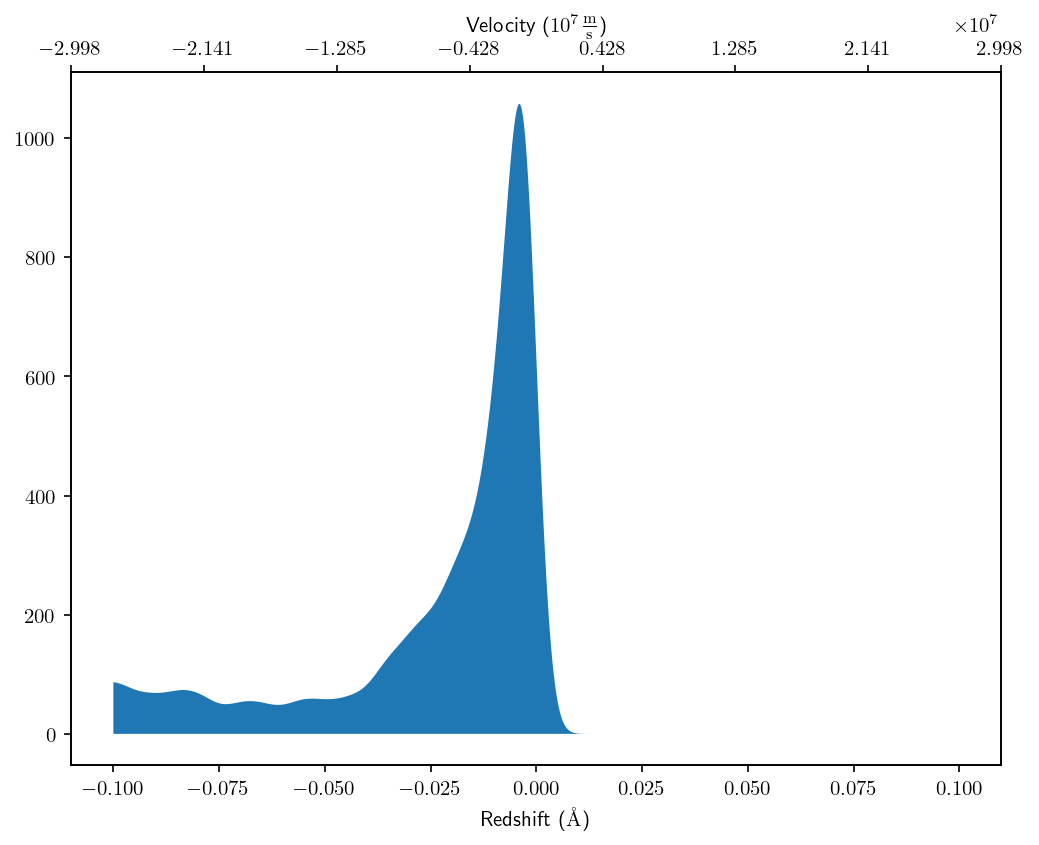

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax_top = ax.twiny()
ax.fill_between(kde_z, kde_y, np.zeros_like(kde_z))
ax_top.set_xticks(np.linspace(-0.1*consts.c.to_value(), 0.1*consts.c.to_value(), 8))
ax.set_xlabel(r'Redshift ($\unit{\angstrom}$)')
ax_top.set_xlabel(r'Velocity ($10^7\frac{\unit{m}}{\unit{s}}$)')
plt.savefig('smoothed_spectra.png')